### Example notebook of how you could apply the feature functions to university of california irvine data

### Created by Ismail Elnaggar 
1. Email: imelna@utu.fi

### Reference to paper where the feature equations are listed


link for feature definitions starting on page 97 out of 108 pages:
https://d-nb.info/1191267180/34

refer to this link for the equations used to create mean and median freq:

https://www.intechopen.com/books/computational-intelligence-in-electromyography-analysis-a-perspective-on-current-applications-and-future-challenges/the-usefulness-of-mean-and-median-frequencies-in-electromyography-analysis


In [2]:
#standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#scipy / signal processing imports
from scipy import signal
from scipy.stats import entropy,mode
from scipy.interpolate import interp1d
from scipy import fftpack
import pywt

#entropy
from entropy import *

#datetime
from datetime import datetime

#other
from collections import defaultdict, Counter
import glob
import pprint as pp
import sys
import time

### Scroll past the feature definitions for example of how functions were used

### you can either import the feature functions from py files or just have them defined in the notebook somewhere.

In [23]:
## Imports of the feature functions
from EMGFEATS import emgamplitude,emgfrequency

### Feature Definitions
1. Amplitude features
2. Frequency features
3. Entropy features
4. Stationarity features
5. Variablity features
6. Linearity Features

### Amplitude Features
1. peak
2. peak to peak mean value (p2pmv)
3. root mean squared (rms)
4. mean of the absolute values of the second differences (mavsd)
5. mean of the absolute values of the first differences (mavfd)
6. mean of the absolute values of the second differences of the normalized signal (mavsdn)
7. mean of the absolute values of the first differences of the normalized signal (mavfdn)
8. mean of local minima values  (mlocminv)
9. mean of local maxima values  (mlocmaxv) 
10. mean of absolute values (mav)

In [24]:
def peak(data): #from emad
    peak=max(data)
    return peak

In [25]:
def p2pmv(data): #from emad
    x=np.array(data)
    mean_p2p=np.mean((max(x)-min(x)))
    return mean_p2p

In [26]:
def rms(data): #from emad
    x=np.array(data)
    y=x.astype(np.float)
    return np.sqrt(np.mean(y**2))

In [27]:
def mavfd(data):
    x=pd.Series(data)
    dif1=abs(x.diff(periods=1))
    return np.sum(dif1)/len(x)

In [28]:
def mavsd(data): 
    x=pd.Series(data)
    dif2=abs(x.diff(periods=2))
    return np.sum(dif2)/len(x)

In [29]:
def mavfdn(data):
    x=np.asarray(data)
    normdata=(x-np.mean(x))/np.std(x)
    fdn=mavfd(normdata)
    return fdn

In [30]:
def mavsdn(data): 
    x=np.asarray(data)
    normdata=(x-np.mean(x))/np.std(x)
    sdn=mavsd(normdata)
    return sdn

In [31]:
def mlocminv(data): #from emad edited by ismail
    x=np.array(data)
    x=x[signal.argrelextrema(x, np.less)[0]]
    minlocx=sorted(x)[:10]
    return np.mean(minlocx)
    #return np.mean(x)

In [32]:
def mlocmaxv(data): #from emad edited by ismail 
    x=np.array(data)
    x=x[signal.argrelextrema(x, np.greater)[0]]
    #return np.mean(x)
    maxlocx=sorted(x, reverse =True)[:10]
    return np.mean(maxlocx)

In [33]:
def mav(data): #from emad edited by ismail
    #x=np.array(data)
    y=[abs(i) for i in data]
    return np.mean(y)

In [34]:
def norm(data): #from emad
    x=np.array(data)
    return (x-np.mean(x))/np.std(x)

### Frequency Features
1. Mean Frequency
2. Median Frequency
3. bandwidth frequency or 3db 
4. center frequency
5. zero crossings
6. mode freq (peak? freq)


In [35]:
def get_fft_values(y_values, fs):
    """When the input a is a time-domain signal and A = fft(a),
    np.abs(A) is its amplitude spectrum and
    np.abs(A)**2 is its power spectrum. The phase spectrum is obtained by np.angle(A).
    
    y_values= time series data
    fs= sampling frequency of the data
    """
    
    realfreq=np.fft.rfftfreq(len(y_values),d = 1.0/fs) #returns real valued portion of fft only 
   
    ####fft_values=(np.fft.rfft(y_values,axis=0)) fft
    ##fft_values=np.abs((np.fft.rfft(y_values,axis=0))) #realfft #AMPLITUDE SPECTRUM
   
    fft_values=np.abs((np.fft.rfft(y_values,axis=0)))**2 #POWER SPECTRUM

    return realfreq, fft_values 

In [36]:
def meanfreq(x,y):
    """mean freq of a spectrum is the sum of the product of the spectrogram intensity
       and the frequency, divided by the total sum of the spectrogram intensity
       x = the frequency bins
       y = the spectrogram intensity
    """
    
    fp_product=0
    p_sum=0
    for i in range(0,len(x)):
        fp_product+=(x[i]*y[i])
        p_sum+=y[i]
    
    return (fp_product/p_sum)

In [37]:
def medianfreq(y):
    """median frequency is a frequency defined as half of the total power or TTP
       (dividing the total power area into two equal parts.)
       x = the frequency bins
       y = power spectrum
    """
    m_sum=sum(y)/2
    i=0
    ystepsum=0
    while i < len(y):
        
        ystepsum+=y[i]
        i+=1
        if ystepsum> m_sum:
            break
    
        
    return float(i)
        
    

In [38]:
def centerfreq(y):
    """
    cf = (𝑓ℎ+ 𝑓𝑙)/2 ,  fl =  lower -3 dB-cut-off frequency, fh =  upper -3 dB-cut-off frequency
    3db or (.7079 in amplitude)
    """
    bwl=[]
    yarr=np.asarray(y)
    maxval=max(yarr)
    thres=maxval*.7079
    peakfreqs=signal.find_peaks(yarr,prominence=(max_power*.50))
    
    if len(peakfreqs[0]) ==0:
        return 0
    else:
        for freq in peakfreqs[0]:
            if yarr[freq] > thres:
                bwl.append(freq)
        if len(bwl)==0:
            
            return 0.0

        return (float(bwl[-1]+bwl[0]))/2

In [39]:
def bwfreq(y):
    
    """
    bw = 3-dB-bandwidth = fh - fl ,  fl = lower -3 dB-cut-off frequency, fh = upper -3 dB-cut-off frequency.
    3db or (.7079 in amplitude)
    
    """
    bwl=[]
    yarr=np.asarray(y)
    maxval=max(yarr)
    thres=maxval*.7079
    peakfreqs=signal.find_peaks(yarr,prominence=(max_power*.50))  ###use lower prominence than ####max_power-(max_power*0.7079)
                                                                   ###.7079 in order to capture all relevant peaks 
    if len(peakfreqs[0]) ==0:
        
        return 0  ### return 0 because no peaks can be found. most likely corrupt signal data in the case of spa2 data
    else:
        for freq in peakfreqs[0]:
            if yarr[freq] > thres:
                bwl.append(freq)
        #print(bwl)    
        if len(bwl)==0:
            
            return 0.0  ### return 0 here is redundant
        if len(bwl)==1:
            #returning 1 as of now is debatable because we could just return the frequency where the peak is 
            return 1.0 ### if there is only one peak above the threshold return 1 as bw 
                       ### this is because of the peak widths being all 1 sample (this is unique to this example)
        else:          ### if the segment used for fft was longer than 500 samples the bin widths would be larger than 1 sample wide.
                       ### This function only works as of now with a data segment length of 500 samples and Fs = 500hz 
                
            return float(bwl[-1]-bwl[0]) ### because peakfreqs returns the indexes from small to large
                                         ### you can find the bandwith by taking the difference
                                        ### of the first element from the last element

In [40]:
def zerocross_v2(y): #from  https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
    zero_crossings = np.where(np.diff(np.sign(y)))[0]
    return (len(zero_crossings))

In [41]:
def mode_freq(y):
    """to find the mode, find the maximum value of Y, then the freq corresponding to it.
    x = the frequency bins
    y = power spectrum
    """
    #max_power=max(y)
    #max_index= y.index(max_power)
    #return float(max_index)
    return float(np.argmax(y))

### Entropy Features

Entropy package link : https://raphaelvallat.com/entropy/build/html/index.html

1. Approximate Entropy
2. Sample Entropy
3. Shannon Entropy
4. Spectral Entropy
5. Fuzzy Entropy <---- unsure about this one 


In [ ]:
def ApEn(U, m): #from entropy package
    approx_en=app_entropy(U,order=m)
    return approx_en

In [ ]:
def SampEn(U,m): #from entropy package
    sample_en=sample_entropy(U,order=m)
    return sample_en

In [ ]:
def ShannonEn(y): #https://stackoverflow.com/questions/42683287/python-numpy-shannon-entropy-array
    """y=1-d time series data"""
    proby = y / y.sum()
    se = -np.sum(proby*np.log2(y))
    
    return se

In [ ]:
def spectralEn(y):
    """y=1-d time series data"""
    fft_values=np.abs((np.fft.rfft(y,axis=0)))**2
    psdvals=fft_values/251 # or len(fft_values)
    probdens=psdvals/np.sum(psdvals)
    return -np.sum(probdens*np.log2(probdens))

In [ ]:
# Calculate Fuzzy Entropy   ### not sure of this one yet
def FuzzyEn(U):
    
    fzmean=np.mean(U)
    fzsigma=np.std(U)
    gaussMF=np.exp(-((U - fzmean) ** 2) / float(fzsigma) ** 2)
    sig_GMF=U * gaussMF
    N = len(U)
    m = 2
    r = np.std(U)*0.2
    def _maxdist(x_i, x_j):
        result = max([abs(ua - va) for ua, va in zip(x_i, x_j)])
        return result

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1, 1)] for i in range(N - m + 1)]
#         print('x is ', x)
        C = 0
        for i in range(len(x)):
            for j in range(len(x)):
                if i == j:
                    continue
                C += (_maxdist(x[i], x[j]) <= r)
        return C

    
    return -np.log(_phi(m+1) / _phi(m))

### Stationarity Features
1. Stationarity Mean
2. Srationarity Standard deviation
3. MISSING FEATURES: stationarity median, stationarity freqpond, stationarity area, stationarity area ponderada

In [ ]:
def stationarity_mean(y,n):  ### not sure if this is correct / what the split value should be 
    """
   Split the signal X into n equal, consecutive subsets 𝑋1, 𝑋2, …, 𝑋𝑛. 
   Calculate the mean value of the subsets 𝑥 ̂1, 𝑥 ̂2, …, 𝑥 ̂𝑛  
   Forming  𝑋𝑚𝑒 = {𝑥 ̂1,𝑥 ̂2,…,𝑥 ̂𝑛}
    
    Parameters
    ----------
    y = time series data
    n = number of splits 
    
    Returns
    -------
    standard deviation of 𝑋𝑚𝑒
    """
    yarr=np.asarray(y)
    split_data=np.split(yarr,n)
    setstd = np.asarray(split_data).mean(axis=1)
    
    return np.std(setstd)

In [ ]:
def stationarity_std(y,n):   ### not sure if this is correct / what the split value should be 
    """
    Split the signal X into n equal, consecutive subsets 𝑋1, 𝑋2, …, 𝑋𝑛.
    Calculate the standard deviations of the subsets 𝜎𝑥1,𝜎𝑥2,…,𝜎𝑥𝑛 
    Forming 𝑋𝑠𝑑 = {𝜎𝑥1,𝜎𝑥2,…,𝜎𝑥𝑛}.
 
    
    Parameters
    ----------
    y = time series data
    n = number of splits 
    
    Returns
    -------
    standard deviation of 𝑋𝑠𝑑
    """
    yarr=np.asarray(y)
    split_data=np.split(yarr,n)
    setstd = np.asarray(split_data).std(axis=1)
    
    return np.std(setstd)

### Variability Features
1. range
2. inter range

In [45]:
def rang(data): #from emad 
    x=np.array(data)
    #x=x.astype(np.float)
    return max(x)-min(x)  

In [46]:
def intrange(data): #from emad 
    x=np.array(data)
    x=x.astype(np.float)
    q75, q25 = np.percentile(x,[75, 25])
    iqr = q75-q25
    return iqr

  var and std features can be just applied to numpy arrays or pandas series via built in methods

### Linearity Features
1. Lag dependent function
2. parital lag dependence functions
3. both these features have yet to be implemented

In [43]:
## lag dependent functions
def ldf():
    pass

In [44]:
## partial lag dependence functions
def pldf():
    pass


### Importing a patient for this example

doing it manually for this example

In [6]:
# just importing a few patients for this example
#patient 4, 5, and 6
emg04 = pd.read_csv("S:/Shared with me/uci_data/02-uci_raw/uci_raw_emg/uci_raw_emg_updated_time/uci_emg_time_updated_p04.csv",header=0,dtype=np.float64)
emg05 = pd.read_csv("S:/Shared with me/uci_data/02-uci_raw/uci_raw_emg/uci_raw_emg_updated_time/uci_emg_time_updated_p05.csv",header=0,dtype=np.float64)
emg06 = pd.read_csv("S:/Shared with me/uci_data/02-uci_raw/uci_raw_emg/uci_raw_emg_updated_time/uci_emg_time_updated_p06.csv",header=0,dtype=np.float64)

In [47]:
emg04.columns=["time","raw_fro","raw_corru","raw_orbi","raw_lev","raw_zyg","raw_trap","filt_fro",
              "filt_corru","filt_orbi","filt_lev","filt_zyg","filt_trap"]
emg05.columns=["time","raw_fro","raw_corru","raw_orbi","raw_lev","raw_zyg","raw_trap","filt_fro",
              "filt_corru","filt_orbi","filt_lev","filt_zyg","filt_trap"]
emg06.columns=["time","raw_fro","raw_corru","raw_orbi","raw_lev","raw_zyg","raw_trap","filt_fro",
              "filt_corru","filt_orbi","filt_lev","filt_zyg","filt_trap"]

In [50]:
#just taking the filtered signals here 
filtemg04=emg04.iloc[:,7:].copy()
filtemg04.insert(0,"time",emg04["time"])

#just taking the filtered signals here 
filtemg05=emg05.iloc[:,7:].copy()
filtemg05.insert(0,"time",emg05["time"])

#just taking the filtered signals here 
filtemg06=emg06.iloc[:,7:].copy()
filtemg06.insert(0,"time",emg06["time"])

filterdict=dict()
filterdict["patient04"]=filtemg04
filterdict["patient05"]=filtemg05
filterdict["patient06"]=filtemg06

In [49]:
print (filtemg04.head())

           time       filt_fro     filt_corru      filt_orbi       filt_lev  \
0  1.530567e+09 -129317.633651 -413659.268023 -247205.847013 -614663.853471   
1  1.530567e+09   -8170.077041  142201.068819   50239.813009  270957.809848   
2  1.530567e+09   25416.340369  160323.769017   79864.422093  265325.811480   
3  1.530567e+09   27695.172153   86391.996709   52706.240558  126186.988981   
4  1.530567e+09   47187.151831  108747.213616   72679.393609  147014.661157   

        filt_zyg     filt_trap  
0 -335385.650011  3.931227e+06  
1   98484.907562  1.285816e+06  
2  122107.157774 -3.255179e+05  
3   71244.613603 -8.817711e+05  
4   91786.472654 -1.626217e+06  


In [ ]:
filtemg04.plot(subplots=True, figsize =(6,8))


### Applying feature functions


 I did it basically the following way because I only created a few features at a time so I could check them afterwards without having to wait for all the features to be create which could take awhile if you ran all the functions at the same time. 

### Time domain feature segmentation example

In [ ]:
### Because Fs=500 and we want 1 second long segments for the features we can split
### the signal into 500 sample segments in order to capture 1 second long samples

S=500 
N=len(filtemg04)//S 
chunks=[filtemg04.iloc[j*S:(j+1)*S,1:7].copy() for j in range(N+1)] #select only emg channels
if len(chunks[-1]) != 500: ###delete the last segment because it most likely will be less
    del chunks[-1]         ###than 500 samples long

### main loop to create whatever time domain feature you want to use

In [53]:
### loop to create features manually by applying a given function to a segment of a signal

featuredict=dict()

mavlist=[]
rmslist=[]


#freqbins=list(range(251))
FeatKeys=["mav","rms"]
for k in filterdict:
    print (k)
    S=500
    N=len(filterdict[k])//S
    chunks=[filterdict[k].iloc[j*S:(j+1)*S,1:7].copy() for j in range(N+1)]
    if len(chunks[-1]) != 500:
        del chunks[-1]
    featuredict[k]={key: [] for key in FeatKeys}
    for m in range(0,len(chunks)):
        mavs=chunks[m].apply(lambda y: mav(y))
        rmss=chunks[m].apply(lambda y: rms(y))

        mavlist.append(mavs)
        rmslist.append(rmss)

        
    featuredict[k]["mav"].append(mavlist)
    featuredict[k]["rms"].append(rmslist)

    #clear lists after each patient
    mavlist=[]
    rmslist=[]

patient04
patient05
patient06


In [55]:
#combine the created features

Features=dict() 

   
for k in featuredict:
    print (k)
    
    rmspd = pd.DataFrame(featuredict[k]["rms"][0])
    rmspd.columns= ["rms_fro","rms_cor","rms_orb","rms_lev","rms_zyg","rms_Trap"]
    mavpd = pd.DataFrame(featuredict[k]["mav"][0])
    mavpd.columns= ["mav_fro","mav_cor","mav_orb","mav_lev","mav_zyg","mav_Trap"]
    
    #either concat to existing features or start with inital features then keep updating it
    #Features[k]=pd.concat([myFeats_dict[k],bwf,cntf],axis=1)
    
    Features[k]=pd.concat([rmspd,mavpd],axis=1)

patient04
patient05
patient06


In [56]:
print (Features["patient04"].head())

       rms_fro       rms_cor       rms_orb       rms_lev       rms_zyg  \
0  9686.833601  28621.487205  16886.991931  43799.909514  23051.287106   
1   468.949884    435.037345    502.622074    184.540618    539.976196   
2   481.722983    440.294398    598.087823    457.611101    481.184397   
3   593.759259    391.443931    588.630930    475.846391    460.969792   
4   593.981592    392.788353    503.049847    512.007096    457.941966   

        rms_Trap      mav_fro      mav_cor      mav_orb       mav_lev  \
0  326727.936401  3716.767325  7863.141817  4975.148779  11680.847370   
1     904.314620   362.465309   337.769876   397.130695     98.406463   
2      35.821324   363.986345   346.559845   454.243008    320.419777   
3      34.895140   453.280550   311.326754   457.992079    380.698976   
4      39.826893   447.222790   311.342715   391.446789    396.288423   

       mav_zyg      mav_Trap  
0  6801.018649  89790.482890  
1   416.271541    431.545806  
2   370.668459     28.6

### Frequency Domain segmentation example

### IMPORTANT: 
The way im doing the segmentation will only work if you're using 1 second segments you need to edit this if you decide on a different length

### First transform from time to freq domain

In [57]:
fft_dict=dict()
fft_list=[]
for k in filterdict:
    print (k)
    S=500
    N=len(filterdict[k])//S
    chunks=[filterdict[k].iloc[j*S:(j+1)*S,0:6].copy() for j in range(N+1) ]

    for m in range(0,len(chunks)):

        x=chunks[m].apply(lambda y: np.abs(np.fft.rfft(y))**2)
        fft_list.append(x)
    fft_dict[k]=pd.concat(fft_list)
    fft_dict[k].columns=["filt_EMG_fro","filt_EMG_cor","filt_EMG_orb","filt_EMG_lev","filt_EMG_zyg","filt_EMG_Trap"]
    fft_list=[]

patient04
patient05
patient06


### Because Fs=500 we can only capture frequencies from 0 to 250 hz (Fs/2)
so the segments will be 251 samples long 

In [58]:
###loop to create the mean, median, and mode freq features

freqdict=dict()

mean_list=[]
med_list=[]
mode_list=[]
freqbins=list(range(251))
FeatKeys=["meanFreq","medianFreq","modeFreq"]

for k in fft_dict:
    print (k)
    S=251
    N=len(fft_dict[k])//S
    chunks=[fft_dict[k].iloc[j*S:(j+1)*S,0:6].copy() for j in range(N+1)]
    if len(chunks[-1]) != 251:
        del chunks[-1]
    freqdict[k]={key: [] for key in FeatKeys}
    
    for m in range(0,len(chunks)):
        meanf=chunks[m].apply(lambda y: meanfreq(freqbins,y))
        medf=chunks[m].apply(lambda y: medianfreq(y))
        modef=chunks[m].apply(lambda y: mode_freq(y))
        mean_list.append(meanf)
        med_list.append(medf)
        mode_list.append(modef)
        
    freqdict[k]["meanFreq"].append(mean_list)
    freqdict[k]["medianFreq"].append(med_list)
    freqdict[k]["modeFreq"].append(mode_list)
    mean_list=[]
    med_list=[]
    mode_list=[]
    

patient04


C:\Users\imelna\anaconda\envs\emgEnv\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


patient05
patient06


In [59]:
#loop to combine all features created in this notebook together 

FeatureDict=dict()

   
for k in freqdict:
    print (k)
    
    meanf = pd.DataFrame(freqdict[k]["meanFreq"][0])
    meanf.columns= ["meanfreq_fro","meanfreq_cor","meanfreq_orb","meanfreq_lev","meanfreq_zyg","meanfreq_Trap"]
    medf = pd.DataFrame(freqdict[k]["medianFreq"][0])
    medf.columns= ["medfreq_fro","medfreq_cor","medfreq_orb","medfreq_lev","medfreq_zyg","medfreq_Trap"]
    modef = pd.DataFrame(freqdict[k]["modeFreq"][0])
    modef.columns= ["modefreq_fro","modefreq_cor","modefreq_orb","modefreq_lev","modefreq_zyg","modefreq_Trap"]
    
    
    FeatureDict[k]=pd.concat([Features[k],meanf,medf,modef],axis=1)

patient04
patient05
patient06


In [69]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', 200)
    display(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

### All the features from this example combined into one dataframe for each patient. 
1. Patient 6 shown below

In [96]:
print_full(FeatureDict["patient06"].head(10))

,rms_fro,rms_cor,rms_orb,rms_lev,rms_zyg,rms_Trap,mav_fro,mav_cor,mav_orb,mav_lev,mav_zyg,mav_Trap,meanfreq_fro,meanfreq_cor,meanfreq_orb,meanfreq_lev,meanfreq_zyg,meanfreq_Trap,medfreq_fro,medfreq_cor,medfreq_orb,medfreq_lev,medfreq_zyg,medfreq_Trap,modefreq_fro,modefreq_cor,modefreq_orb,modefreq_lev,modefreq_zyg,modefreq_Trap
0,30231.922157,16233.145696,26622.695285,17237.717077,22982.873082,303104.704971,8608.314422,4738.941173,7646.174237,5159.261472,6666.647789,79899.709726,7.186224e-20,120.396719,89.133421,116.960644,85.952185,110.526284,1.0,115.0,65.0,110.0,57.0,100.0,0.0,28.0,23.0,28.0,21.0,23.0
1,519.943004,506.008048,528.850090,900.483116,579.147758,1123.391001,413.261919,408.084710,424.781314,570.621717,467.656494,527.348399,7.186224e-20,99.058902,95.988730,100.618780,45.761860,100.008334,1.0,87.0,86.0,89.0,26.0,89.0,0.0,55.0,55.0,55.0,19.0,55.0
2,546.071709,532.078133,613.334635,1123.276285,608.782446,43.439094,428.333126,419.639431,473.428397,715.266561,479.929843,32.941964,7.186225e-20,90.404921,92.148296,92.530859,38.060851,93.734760,1.0,79.0,83.0,88.0,24.0,86.0,0.0,69.0,37.0,29.0,20.0,29.0
3,621.500235,611.095080,620.809662,884.734708,652.197951,42.153099,492.017540,482.730354,494.578517,601.915435,517.340109,33.467811,7.186223e-20,87.256822,86.988476,88.047011,51.428192,89.233778,1.0,76.0,76.0,76.0,28.0,77.0,0.0,47.0,47.0,47.0,19.0,36.0
4,473.184783,468.731287,476.498079,845.671935,534.939217,35.292960,375.447216,372.823925,377.524871,531.356795,422.794172,27.921113,7.186223e-20,94.940269,94.691694,94.493315,47.150020,94.806233,1.0,84.0,84.0,83.0,26.0,83.0,0.0,69.0,34.0,45.0,25.0,70.0
5,525.886974,517.305667,525.045761,1200.629965,563.900738,36.539937,421.334694,411.412324,419.920031,753.172838,455.641722,29.592777,7.186224e-20,89.760080,89.461877,92.111168,36.329872,96.906137,1.0,80.0,80.0,80.0,25.0,87.0,0.0,29.0,29.0,66.0,20.0,66.0
6,463.428774,464.066034,496.280667,849.001292,520.941419,34.269908,368.682671,368.488878,393.556463,524.079649,411.560282,27.202737,7.186224e-20,88.914406,88.464284,93.798983,43.720552,96.953709,1.0,79.0,79.0,84.0,26.0,89.0,0.0,39.0,89.0,39.0,21.0,89.0
7,514.792888,516.631532,714.673308,922.070771,592.162859,39.102130,417.766901,420.649945,568.927706,583.081954,473.346612,31.443187,7.186226e-20,89.152057,88.595659,91.681819,43.905039,89.977828,1.0,77.0,77.0,79.0,25.0,79.0,0.0,71.0,71.0,71.0,20.0,41.0
8,508.658922,506.602233,712.617506,1174.887501,557.190944,38.787332,408.642228,408.180415,576.636434,738.484604,446.127231,30.789872,7.186224e-20,88.068273,87.298290,89.619845,34.907116,91.916157,1.0,80.0,79.0,83.0,24.0,83.0,0.0,77.0,77.0,38.0,20.0,77.0
9,504.092555,504.270930,561.370344,933.506806,550.959067,35.092539,403.422856,400.792110,450.267231,576.080481,436.365202,27.945669,7.186225e-20,85.408986,84.685197,91.762461,41.615818,90.420354,1.0,73.0,72.0,89.0,26.0,80.0,0.0,56.0,56.0,38.0,23.0,64.0


print_full(FeatureDict["patient05"].head(10))

### Small observation that i just noticed for the frontalis muscle:

I think there might have been a mistake when filtering the frontalis muscle in the UCI data. 
When you plot the frequency domain of a segment you see a massive peak at 0hz.
I see it for all three patients 4,5, and 6 that I made this example for.

I don't have time right now to look into it further but I tihkn the problem could be
because when filtering the signal the mean of the signal wasn't subracted from the signal itself. I'm not 100% sure though. 

I made two plots from two different muscles at the plotted from the same time segment to show the difference below

In [99]:
k="patient05"
freqbins=list(range(251))
S=251
N=len(fft_dict[k])//S
chunks=[fft_dict[k].iloc[j*S:(j+1)*S,0:6].copy() for j in range(N+1)]
if len(chunks[-1]) != 251:
    del chunks[-1]

In [100]:
yfro=chunks[266]["filt_EMG_fro"] # selected a random segment
xfrotest=meanfreq(freqbins,yfro)

print (xfrotest)

7.186258637044989e-20


[]


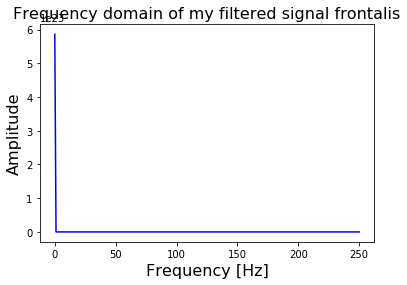

In [101]:
max_power=max(yfro)
peaks, _=signal.find_peaks(yfro,prominence=(max_power*0.50)) #max_power-(max_power*0.7079)
print (peaks)

plt.plot(yfro[:len(yfro)],linestyle='-', color='blue')
plt.plot(peaks,yfro[peaks],"x",color='red')
#plt.plot(range(230,251), chunks[239]["filt_EMG_lev"][230:251], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16) #[502:753]
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of my filtered signal frontalis", fontsize=16)
plt.show()


In [102]:
ycor=chunks[266]["filt_EMG_cor"] # selected a random segment
xcortest=meanfreq(freqbins,ycor)

print (xcortest)

77.21661272296413


[ 16  21  29  49  55  74  91 115]


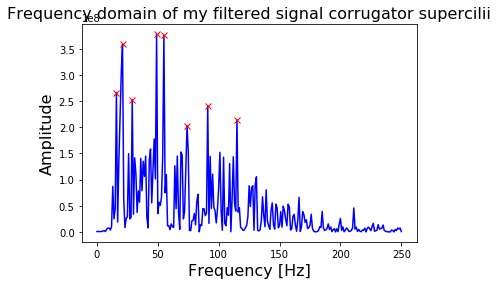

In [103]:
max_power=max(ycor)
peaks, _=signal.find_peaks(ycor,prominence=(max_power*0.50)) #max_power-(max_power*0.7079)
print (peaks)

plt.plot(ycor[:len(ycor)],linestyle='-', color='blue')
plt.plot(peaks,ycor[peaks],"x",color='red')
#plt.plot(range(230,251), chunks[239]["filt_EMG_lev"][230:251], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16) #[502:753]
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of my filtered signal corrugator supercilii", fontsize=16)
plt.show()


Narrow window ===>good time resolution, poor frequency resolution. 
Wide window ===>good frequency resolution, poor time resolution. 